In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import csv
import os
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import FinanceDataReader as fdr
import yfinance as yf
import seaborn as sns
import warnings
warnings.filterwarnings(action = "ignore")

pd.set_option('display.max_rows', None)

# 데이터 로드

## 회사 심볼 및 회사명

In [2]:
stock_list = []
BaseUrl = 'http://finance.naver.com/sise/entryJongmok.nhn?&page='

for i in range(1, 21):
    url = BaseUrl + str(i)
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    items = soup.find_all('td', {'class': 'ctg'})

    for item in items:
        # print(item)
        txt = item.a.get('href') 
        k = re.search('[\d]+', txt) ##정규표현식 사용. [\d] 숫자표현, + : 반복
        
        if k:
            code = k.group()
            name = item.text
            data = code, name
            stock_list.append(data)
            

# 코스피 상위 200 종목 이름 가져오기
stock_name = []            
for i in range(len(stock_list)):
    stock_name.append(stock_list[i][1])
    
stock_code = []
for i in range(len(stock_list)):
    stock_code.append(stock_list[i][0])

In [3]:
a = pd.DataFrame(stock_code)
b = pd.DataFrame(stock_name)
df_krx = pd.concat([a,b], axis=1)
df_krx.columns = ["Symbol","Name"]
df_krx.head()

,Symbol,Name
0,005930,삼성전자
1,373220,LG에너지솔루션
2,000660,SK하이닉스
3,207940,삼성바이오로직스
4,051910,LG화학


## 업종

In [4]:
krx = fdr.StockListing("KRX")
df_kospi_200 = pd.merge(left=df_krx, right=krx, how="left", on="Symbol")
df_kospi_200 = df_kospi_200[["Symbol","Name_x","Sector"]]
df_kospi_200.columns = ["Symbol", "Name", "Sector"]
df_kospi_200.head()

,Symbol,Name,Sector
0,005930,삼성전자,통신 및 방송 장비 제조업
1,373220,LG에너지솔루션,일차전지 및 축전지 제조업
2,000660,SK하이닉스,반도체 제조업
3,207940,삼성바이오로직스,기초 의약물질 및 생물학적 제제 제조업
4,051910,LG화학,기초 화학물질 제조업


In [5]:
df_kospi_200.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Symbol  200 non-null    object
 1   Name    200 non-null    object
 2   Sector  200 non-null    object
dtypes: object(3)
memory usage: 6.2+ KB


## 2022년 주가 데이터

In [6]:
close_list = []
start_date = '2022-12-01'
end_date = '2022-12-31'
for i in (df_kospi_200["Symbol"]):
    print(i)
    try:
        close = yf.download(f'{i}.KS', start_date, end_date)["Adj Close"]
        close = pd.DataFrame(close)
        close.columns = [i]
        close_list.append(close)
    except:
        pass

df_close = pd.concat(close_list, axis=1)
df_close.sort_index(inplace=True)

df_close.head()

005930
[*********************100%***********************]  1 of 1 completed
373220
[*********************100%***********************]  1 of 1 completed
000660
[*********************100%***********************]  1 of 1 completed
207940
[*********************100%***********************]  1 of 1 completed
051910
[*********************100%***********************]  1 of 1 completed
006400
[*********************100%***********************]  1 of 1 completed
005380
[*********************100%***********************]  1 of 1 completed
035420
[*********************100%***********************]  1 of 1 completed
035720
[*********************100%***********************]  1 of 1 completed
000270
[*********************100%***********************]  1 of 1 completed
005490
[*********************100%***********************]  1 of 1 completed
105560
[*********************100%***********************]  1 of 1 completed
068270
[*********************100%***********************]  1 of 1 completed
028260
[****

,005930,373220,000660,207940,051910,006400,005380,035420,035720,000270,...,294870,005440,020000,284740,057050,003850,105630,004490,381970,241590
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-01,62600.0,585000.0,84700.0,884000.0,722000.0,726000.0,171500.0,187500.0,57900.0,68600.0,...,11550.0,7140.0,26600.0,32700.0,50600.0,10750.0,15471.021484,48250.0,14050.0,9600.0
2022-12-02,60400.0,584000.0,81900.0,870000.0,711000.0,718000.0,169000.0,185500.0,56900.0,66500.0,...,11300.0,7020.0,26250.0,32200.0,50200.0,10750.0,15568.018555,51000.0,13850.0,9600.0
2022-12-05,60300.0,562000.0,81000.0,833000.0,696000.0,697000.0,165500.0,191500.0,58000.0,65600.0,...,11550.0,6960.0,26650.0,32600.0,51000.0,10600.0,15859.009766,48650.0,13550.0,9600.0
2022-12-06,59200.0,559000.0,81000.0,838000.0,686000.0,706000.0,164500.0,185500.0,56000.0,65100.0,...,11150.0,6930.0,25900.0,32100.0,51000.0,10700.0,15471.021484,48000.0,13200.0,9450.0
2022-12-07,58900.0,563000.0,78900.0,831000.0,679000.0,708000.0,163000.0,183500.0,55500.0,65000.0,...,10900.0,6780.0,26600.0,32500.0,53100.0,10850.0,15034.535156,47750.0,13200.0,9360.0


## Clustering

In [7]:
kospi200 = df_close.pct_change().iloc[1:].T     #----- 수익률 
kospi200 = kospi200.dropna(how="any")           #----- NaN값 처리
kospi200.head()                                 #----- 199개 기업들을 대상으로 군집 시도               

Date,2022-12-02,2022-12-05,2022-12-06,2022-12-07,2022-12-08,2022-12-09,2022-12-12,2022-12-13,2022-12-14,2022-12-15,2022-12-16,2022-12-19,2022-12-20,2022-12-21,2022-12-22,2022-12-23,2022-12-26,2022-12-27,2022-12-28,2022-12-29
005930,-0.035144,-0.001656,-0.018242,-0.005068,0.005093,0.020270,-0.014901,0.003361,0.013400,-0.019835,0.003373,0.000000,-0.015126,-0.010239,0.018966,-0.016920,-0.003442,0.003454,-0.025818,-0.022968
373220,-0.001709,-0.037671,-0.005338,0.007156,-0.056838,-0.030132,-0.025243,-0.010956,0.004028,-0.025075,-0.001029,-0.007209,0.011411,-0.021538,-0.011530,-0.033934,0.004391,-0.001093,-0.044858,-0.002291
000660,-0.033058,-0.010989,0.000000,-0.025926,-0.001267,0.034264,-0.004908,0.014797,-0.006075,-0.019560,-0.022444,0.007653,-0.008861,-0.003831,0.015385,-0.017677,-0.010283,0.000000,-0.012987,-0.013158
207940,-0.015837,-0.042529,0.006002,-0.008353,-0.004813,0.000000,-0.014510,0.006135,0.020732,-0.016726,0.014581,-0.016766,-0.001218,-0.002439,0.007335,-0.021845,0.019851,0.007299,0.002415,-0.010843
051910,-0.015235,-0.021097,-0.014368,-0.010204,-0.013255,-0.064179,0.001595,-0.007962,0.036918,-0.004644,0.003110,-0.018605,-0.003160,-0.017433,0.009677,-0.025559,0.013115,0.016181,-0.041401,-0.003322


In [8]:
companies = list(kospi200.index)    #----- 회사 심볼 저장
companies
movements = kospi200.values         #----- 회사 수익률 저장
movements

array([[-0.03514377, -0.00165563, -0.01824212, ...,  0.00345423,
        -0.02581756, -0.0229682 ],
       [-0.0017094 , -0.03767123, -0.00533808, ..., -0.0010929 ,
        -0.04485777, -0.00229095],
       [-0.03305785, -0.01098901,  0.        , ...,  0.        ,
        -0.01298701, -0.01315789],
       ...,
       [ 0.05699482, -0.04607843, -0.01336074, ...,  0.        ,
        -0.01460674, -0.03420753],
       [-0.01423488, -0.02166065, -0.02583026, ...,  0.00396825,
        -0.01581028, -0.07228916],
       [ 0.        ,  0.        , -0.015625  , ...,  0.04301075,
        -0.01752577, -0.03147954]])

In [9]:
# 데이터 정규화
normalize = Normalizer()
norm_array = normalize.fit_transform(kospi200)
df_norm = pd.DataFrame(norm_array, columns = kospi200.columns)
final_df = df_norm.set_index(kospi200.index)
final_df.head(10)

Date,2022-12-02,2022-12-05,2022-12-06,2022-12-07,2022-12-08,2022-12-09,2022-12-12,2022-12-13,2022-12-14,2022-12-15,2022-12-16,2022-12-19,2022-12-20,2022-12-21,2022-12-22,2022-12-23,2022-12-26,2022-12-27,2022-12-28,2022-12-29
005930,-0.494625,-0.023302,-0.256746,-0.071323,0.071686,0.285291,-0.209717,0.047309,0.188601,-0.279160,0.047468,0.000000,-0.212889,-0.144106,0.266927,-0.238144,-0.048449,0.048616,-0.363365,-0.323262
373220,-0.016290,-0.358984,-0.050869,0.068189,-0.541636,-0.287138,-0.240548,-0.104406,0.038386,-0.238952,-0.009804,-0.068698,0.108738,-0.205249,-0.109878,-0.323373,0.041842,-0.010415,-0.427468,-0.021831
000660,-0.450861,-0.149874,0.000000,-0.353592,-0.017286,0.467311,-0.066938,0.201803,-0.082859,-0.266769,-0.306102,0.104377,-0.120848,-0.052255,0.209824,-0.241085,-0.140242,0.000000,-0.177124,-0.179455
207940,-0.229810,-0.617128,0.087100,-0.121212,-0.069848,0.000000,-0.210556,0.089024,0.300834,-0.242714,0.211580,-0.243295,-0.017675,-0.035392,0.106436,-0.316984,0.288056,0.105919,0.035050,-0.157346
051910,-0.150058,-0.207791,-0.141513,-0.100503,-0.130550,-0.632118,0.015709,-0.078418,0.363617,-0.045740,0.030635,-0.183242,-0.031119,-0.171699,0.095316,-0.251739,0.129171,0.159373,-0.407773,-0.032722
006400,-0.103658,-0.275134,0.121467,0.026649,-0.199300,-0.651564,0.072922,-0.101306,0.351115,-0.028207,0.028292,-0.282068,-0.029079,-0.160429,0.044512,-0.221514,0.030247,0.000000,-0.316580,-0.187203
005380,-0.223940,-0.318153,-0.092823,-0.140081,-0.094247,0.047414,0.094537,-0.375835,0.385261,-0.140938,0.047414,-0.330880,-0.193236,-0.097849,0.246190,-0.145384,0.097849,0.000000,-0.388918,-0.299265
035420,-0.100308,0.304169,-0.294639,-0.101390,0.102495,0.481602,-0.096450,0.000000,0.024362,-0.534589,-0.103056,0.156298,-0.153742,-0.026050,0.235098,-0.331303,0.026415,0.131707,-0.051955,-0.130610
035720,-0.164764,0.184425,-0.328959,-0.085177,0.000000,0.446910,0.000000,0.016420,0.081957,-0.552562,-0.155259,0.245510,-0.256447,-0.017569,0.158410,-0.294332,0.035730,0.142385,-0.140291,-0.088991
000270,-0.332441,-0.146974,-0.082772,-0.016682,-0.050122,0.083924,-0.016656,-0.433723,0.278009,0.000000,0.000000,-0.288012,0.000000,-0.069614,0.262736,-0.136816,0.173202,0.068193,-0.542140,-0.285314


In [10]:
# 클러스터 수 지정(2~12)
num_of_clusters = range(2,12)
# 에러 계산 빈 리스트 생성
error = []

# 가장 중요한 파라미터는 클러스터 개수.
# 클러스터링 후 fit() 함수를 이용해 데이터에 적합시킵니다.
for num_clusters in num_of_clusters:
    clusters = KMeans(num_clusters)
    clusters.fit(final_df)
    error.append(clusters.inertia_/100)    

# 계산된 값 데이터프레임으로 return
table=pd.DataFrame({"Cluster_Numbers":num_of_clusters, "Error_Term":error})

table

,Cluster_Numbers,Error_Term
0,2,1.302589
1,3,1.219692
2,4,1.143541
3,5,1.090204
4,6,1.045806
5,7,1.009873
6,8,0.991045
7,9,0.966844
8,10,0.938843
9,11,0.919616


KElbowVisualizer(ax=<AxesSubplot: >, estimator=KMeans(n_clusters=11), k=(2, 12))

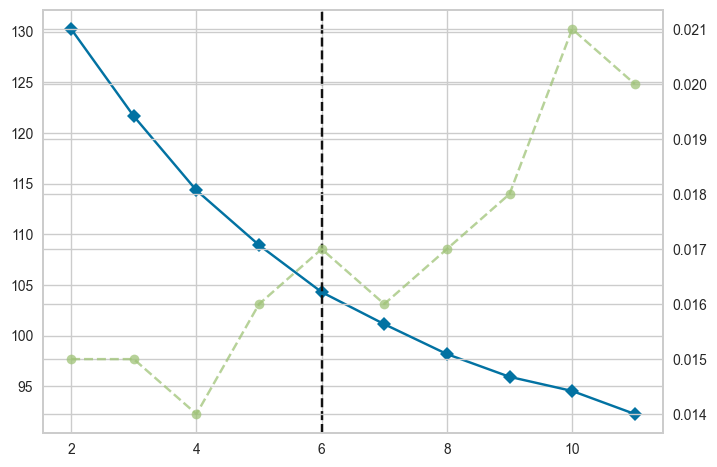

In [11]:
# KMeans 알고리즘에서 최적의 클러스터를 선택하기 위해서는 엘보(elbow) 방법과 실루엣(silhouette) 방법을 사용
# 엘보(elbow) : 군집을 추가로 늘려가면서 군집내 변동성이 급감하는 개수를 찾는 방법
# 실루엣(silhouette) : 각 데이터별로 그 데이터가 속한 군 내의 유사도와 인접한 군의 유사도를 비교하는 지표(거리기반)

model = KMeans()
visualizer = KElbowVisualizer(model, k = (2,12))
visualizer.fit(final_df)

In [12]:
dddddd

NameError: name 'dddddd' is not defined

In [13]:
clusters = KMeans(6, random_state=1111)
clusters.fit(final_df)
clusters.labels_

labels = clusters.predict(movements)
print(labels)

cluster= pd.DataFrame({'labels' : labels, 'Symbol':companies})
cluster.head()

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 1 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 5 5 5 5 3 5 5 3 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


,labels,Symbol
0,5,005930
1,5,373220
2,5,000660
3,5,207940
4,5,051910


In [ ]:
# 군집에 따른 회사명과 업종 데이터프레임 합쳐서 확인하기 
clustered_result = pd.merge(left=cluster, right=df_kospi_200, how="inner", on="Symbol")
clustered_result.sort_values("labels")

,labels,Symbol,Name,Sector
0,0,005930,삼성전자,통신 및 방송 장비 제조업
127,0,006360,GS건설,건물 건설업
128,0,001440,대한전선,절연선 및 케이블 제조업
129,0,111770,영원무역,상품 종합 도매업
130,0,000990,DB하이텍,반도체 제조업
131,0,047040,대우건설,건물 건설업
132,0,007310,오뚜기,기타 식품 제조업
133,0,000080,하이트진로,알코올음료 제조업
134,0,298020,효성티앤씨,화학섬유 제조업
135,0,079550,LIG넥스원,무기 및 총포탄 제조업


In [ ]:
final_df['Cluster'] = clusters.labels_
final_df.head()

Date,2022-12-02 00:00:00,2022-12-05 00:00:00,2022-12-06 00:00:00,2022-12-07 00:00:00,2022-12-08 00:00:00,2022-12-09 00:00:00,2022-12-12 00:00:00,2022-12-13 00:00:00,2022-12-14 00:00:00,2022-12-15 00:00:00,...,2022-12-19 00:00:00,2022-12-20 00:00:00,2022-12-21 00:00:00,2022-12-22 00:00:00,2022-12-23 00:00:00,2022-12-26 00:00:00,2022-12-27 00:00:00,2022-12-28 00:00:00,2022-12-29 00:00:00,Cluster
005930,-0.494625,-0.023302,-0.256746,-0.071323,0.071686,0.285291,-0.209717,0.047309,0.188601,-0.279160,...,0.000000,-0.212889,-0.144106,0.266927,-0.238144,-0.048449,0.048616,-0.363365,-0.323262,1
373220,-0.016290,-0.358984,-0.050869,0.068189,-0.541636,-0.287138,-0.240548,-0.104406,0.038386,-0.238952,...,-0.068698,0.108738,-0.205249,-0.109878,-0.323373,0.041842,-0.010415,-0.427468,-0.021831,2
000660,-0.450861,-0.149874,0.000000,-0.353592,-0.017286,0.467311,-0.066938,0.201803,-0.082859,-0.266769,...,0.104377,-0.120848,-0.052255,0.209824,-0.241085,-0.140242,0.000000,-0.177124,-0.179455,0
207940,-0.229810,-0.617128,0.087100,-0.121212,-0.069848,0.000000,-0.210556,0.089024,0.300834,-0.242714,...,-0.243295,-0.017675,-0.035392,0.106436,-0.316984,0.288056,0.105919,0.035050,-0.157346,2
051910,-0.150058,-0.207791,-0.141513,-0.100503,-0.130550,-0.632118,0.015709,-0.078418,0.363617,-0.045740,...,-0.183242,-0.031119,-0.171699,0.095316,-0.251739,0.129171,0.159373,-0.407773,-0.032722,2


In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x = 'Cluster', data = final_df)
plt.title('Cluster_count')
plt.show()
plt.savefig('cluster_count.png', dpi=300)

ValueError: Could not interpret input 'Cluster'

<Figure size 1200x600 with 0 Axes>

In [ ]:
# 금융 및 보험 관련 기업들이 분포
clustered_result.groupby('labels').get_group(0)

,labels,Symbol,Name,Sector
0,0,005930,삼성전자,통신 및 방송 장비 제조업
1,0,373220,LG에너지솔루션,일차전지 및 축전지 제조업
2,0,000660,SK하이닉스,반도체 제조업
3,0,207940,삼성바이오로직스,기초 의약물질 및 생물학적 제제 제조업
4,0,051910,LG화학,기초 화학물질 제조업
5,0,006400,삼성SDI,일차전지 및 축전지 제조업
6,0,005380,현대차,자동차용 엔진 및 자동차 제조업
7,0,035420,NAVER,"자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업"
8,0,035720,카카오,"자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업"
9,0,000270,기아,자동차용 엔진 및 자동차 제조업


In [ ]:
# IT 및 화학 관련 기업들이 분포
clustered_result.groupby('labels').get_group(1)

KeyError: 1

In [ ]:
# 자동차 관련 기업들이 분포
clustered_result.groupby('labels').get_group(2)

KeyError: 2

In [ ]:
# 여가 관련 기업들이 분포
clustered_result.groupby('labels').get_group(3)

KeyError: 3

In [ ]:
# 건축 관련 기업들이 분포
clustered_result.groupby('labels').get_group(4)

KeyError: 4